In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import xarray as xr
import geopandas as gpd

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch_geometric
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn.inits import uniform
from torch.nn import Parameter as Param
from torch import Tensor 
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
from torch_geometric.nn.conv import MessagePassing

In [4]:
DATA_DIR = "data/raw/cold-wave-data"
NUM_FILES = 15
dataframes = [
    pd.read_csv(os.path.join(DATA_DIR, f"data{i}.csv"))
    for i in range(1, NUM_FILES + 1)
]
all_stations = {
    name for df in dataframes
    for name in df['NAME'].unique()
}
print(len(all_stations))
all_stations_list = list(all_stations)
station_data_filtered = [
    df.loc[df['NAME'].isin(all_stations_list), ['NAME', 'LATITUDE', 'LONGITUDE']]
    for df in dataframes
]
combined_data = pd.concat(station_data_filtered).drop_duplicates(subset=['NAME'])
combined_data

189


,NAME,LATITUDE,LONGITUDE
0,"GUWAHATI INTERNATIONAL, IN",26.106092,91.585939
151,"TIRUCHIRAPPALLI, IN",10.765364,78.709722
302,"CHENNAI INTERNATIONAL, IN",12.994414,80.180517
453,"BANGALURU INTERNATIONAL AIRPORT, IN",13.200000,77.700000
604,"JAMSHEDPUR, IN",22.813211,86.168844
...,...,...,...
1056,"REWA, IN",24.533333,81.300000
1273,"SHIVAMOGGA, IN",13.858239,75.619825
1858,"TUTICORIN NEW PORT, IN",8.750000,78.183333
2610,"PASHAN CTI, IN",18.533333,73.850000


In [5]:
list_stations = pd.read_csv("data/raw/List of Stations - Sheet1.csv")
list_stations.rename(columns={'STATIONS': 'NAME'}, inplace=True)
final_data = pd.merge(combined_data, list_stations, on='NAME', how='inner')

In [6]:
features = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'DEWP',
            'FRSHTT', 'GUST','MAX', 'MIN','MXSPD', 'PRCP', 'SLP', 'SNDP',
            'STP','TEMP']
filtered_dataframes = [df[features] for df in dataframes]

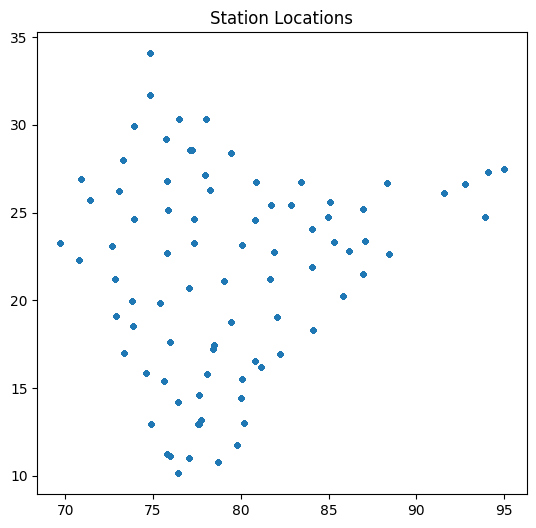

In [7]:
#Map stations using latitude, longitude, and elevation.
gdf = gpd.GeoDataFrame(dataframes[0][['STATION', 'LATITUDE', 'LONGITUDE']],
                       geometry=gpd.points_from_xy(dataframes[0]['LONGITUDE'], dataframes[0]['LATITUDE']))
gdf.plot(markersize=10, figsize=(10, 6))
plt.title("Station Locations")
plt.show()

FRSHTT
0         10160
100000      921
10000       807
10010       244
10           76
110000       56
110010       17
100010       12
10110        11
1000          5
11000         4
1             1
11010         1
Name: count, dtype: int64


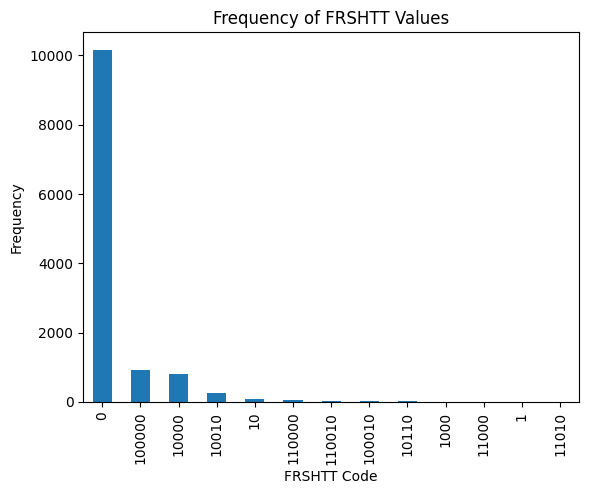

In [8]:
frshtt_counts = dataframes[0]['FRSHTT'].value_counts()
print(frshtt_counts)

frshtt_counts.plot(kind='bar')
plt.title("Frequency of FRSHTT Values")
plt.xlabel("FRSHTT Code")
plt.ylabel("Frequency")
plt.show()

In [9]:
folder_path = 'data/raw/Tmin_longterm_mean'
data_list = []
for file_name in os.listdir(folder_path):
    if file_name.endswith('.nc'):
        file_path = os.path.join(folder_path, file_name)
        dataset = xr.open_dataset(file_path)
        longitude = dataset.t2m.lon.values[0]
        latitude = dataset.t2m.lat.values[0]
        temperatures = dataset.t2m.values[:,0]
        days = []
        for day in range(366):
            date = str(dataset['valid_time'].values[day]).split('T')[0]
            days.append(date)
            
        for day, temp in zip(days, temperatures):
            data_list.append({
                'LATITUDE': latitude,
                'LONGITUDE': longitude,
                'month_day': day[5:],
                'Temperature': temp
            })
T_mean_list = pd.DataFrame(data_list)


In [10]:
for i, df in enumerate(dataframes, start=1):
    df['month_day'] = df['DATE'].str[5:]

In [11]:
#T_mean_list
#T_mean_list.rename(columns={'DATE': 'month_day'}, inplace=True)
updated_dataframes = []
for i, df in enumerate(dataframes, start=1):
    df['month_day'] = df['DATE'].str[5:] 
    merged_df = pd.merge(
        df, T_mean_list,
        on=['LATITUDE', 'LONGITUDE', 'month_day'],  
        how='left' 
    )
    updated_dataframes.append(merged_df)

In [12]:
#Convert the temperature value which are in numpy array format for each data point to simple float data point
for df in updated_dataframes:
    df['Temperature'] = df['Temperature'].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)

In [13]:
again_update_dataframes = []
for i, df in enumerate(updated_dataframes, start=1): 
    merged_df = pd.merge(
        df, final_data,
        on=['LATITUDE', 'LONGITUDE', 'NAME'],  
        how='left' 
    )
    again_update_dataframes.append(merged_df)
dataframes = again_update_dataframes

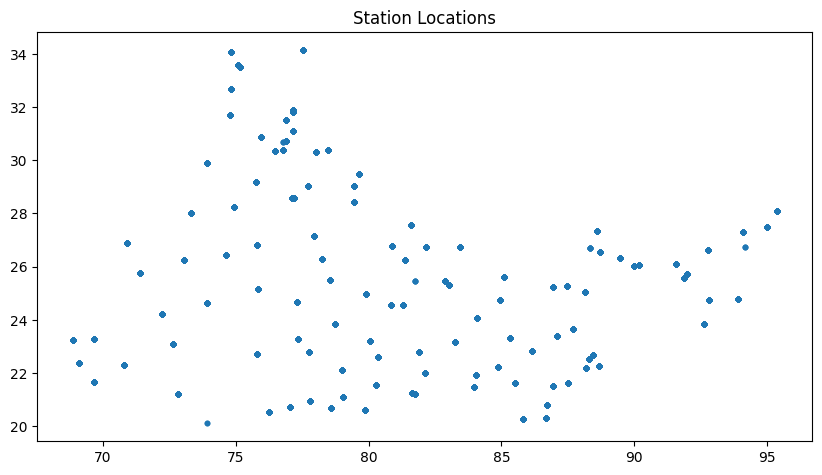

In [14]:
#Drop the stations from the dataframe which are below 20 degree latitude
for i, df in enumerate(dataframes, start=0):
    dataframes[i] = df.loc[df['LATITUDE'] >= 20].reset_index(drop=True)

#Map stations using latitude, longitude, and elevation.
gdf = gpd.GeoDataFrame(dataframes[14][['STATION', 'LATITUDE', 'LONGITUDE']],
                       geometry=gpd.points_from_xy(dataframes[14]['LONGITUDE'], dataframes[14]['LATITUDE']))
gdf.plot(markersize=10, figsize=(10, 6))
plt.title("Station Locations")
plt.show()

In [15]:
#Temperature conversions
for i, df in enumerate(dataframes, start=1):
    if 'MAX' in df.columns:
        df['MAX'] = (df['MAX'] - 32) * 5.0 / 9.0
    if 'MIN' in df.columns:
        df['MIN'] = (df['MIN'] - 32) * 5.0 / 9.0
    if 'TEMP' in df.columns:
        df['TEMP'] = (df['TEMP'] - 32) * 5.0 / 9.0
    if 'DEWP' in df.columns:
        df['DEWP'] = (df['DEWP'] - 32) * 5.0 / 9.0
    if 'Temperature' in df.columns:
        df['Temperature'] = df['Temperature'] - 273.15

In [16]:
# Function to determine cold wave
def is_cold_wave(row):
    if row['TAG'] == 'HILLY' and row['MIN'] <= 0 and (row['Temperature'] - row['MIN']) >= 4.5:
        return 1
    if row['TAG'] == 'NOT HILLY' and row['MIN'] <= 10 and (row['Temperature'] - row['MIN']) >= 4.5:
        return 1  
    return 0

for i , df in enumerate(dataframes , start = 1):
    df['cold_wave'] = df.apply(is_cold_wave, axis=1)

In [17]:
filtered_dataframes = []
for df in dataframes:
    df = df.drop_duplicates(subset=['STATION', 'DATE'])
    station_counts = df.groupby('STATION')['DATE'].nunique()
    valid_stations = station_counts[station_counts >= 100].index
    df_filtered = df[df['STATION'].isin(valid_stations)]
    filtered_dataframes.append(df_filtered)

In [18]:
columns_to_drop = ['FRSHTT', 'GUST', 'SLP', 'SNDP', 'STP', 'month_day', 'STATION']
for i, df in enumerate(filtered_dataframes):
    df.drop(columns=columns_to_drop, inplace = True)

In [19]:
#Making the precipitation feature binary
for i, df in enumerate(filtered_dataframes):
    df['PRCP'] = df['PRCP'].apply(lambda x: 0 if x in [0.00, 99.99] else 1)

In [20]:
# Feature reduction for the MXSPD column
for i , df in enumerate(filtered_dataframes , start = 1):
    df.loc[df['MXSPD'] == 999.9, 'MXSPD'] = 0

In [21]:
for i , df in enumerate(filtered_dataframes , start = 1):
    df['TAG'] = df['TAG'].map({'HILLY': 1, 'NOT HILLY': 0})

In [22]:
combined_df = pd.concat(filtered_dataframes, ignore_index=True)

In [23]:
station_id_mapping = {name: idx for idx, name in enumerate(combined_df['NAME'].unique())}
combined_df['STATION_ID'] = combined_df['NAME'].map(station_id_mapping).astype(int)

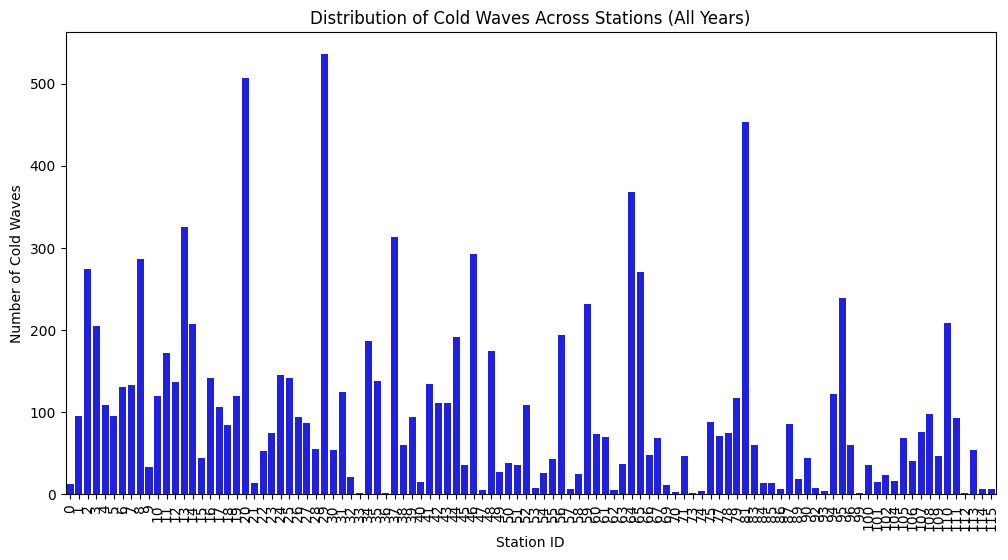

In [24]:
cold_wave_distribution = combined_df[combined_df['cold_wave'] == 1].groupby('STATION_ID').size()
plt.figure(figsize=(12, 6))
sns.barplot(x=cold_wave_distribution.index, y=cold_wave_distribution.values, color='blue')
plt.xlabel('Station ID')
plt.ylabel('Number of Cold Waves')
plt.title('Distribution of Cold Waves Across Stations (All Years)')
plt.xticks(rotation=90)
plt.show()

In [25]:
cold_wave_stations = combined_df[combined_df['cold_wave'] == 1]
station_cold_wave_counts = cold_wave_stations.groupby('NAME').size().reset_index(name='ColdWaveCount')

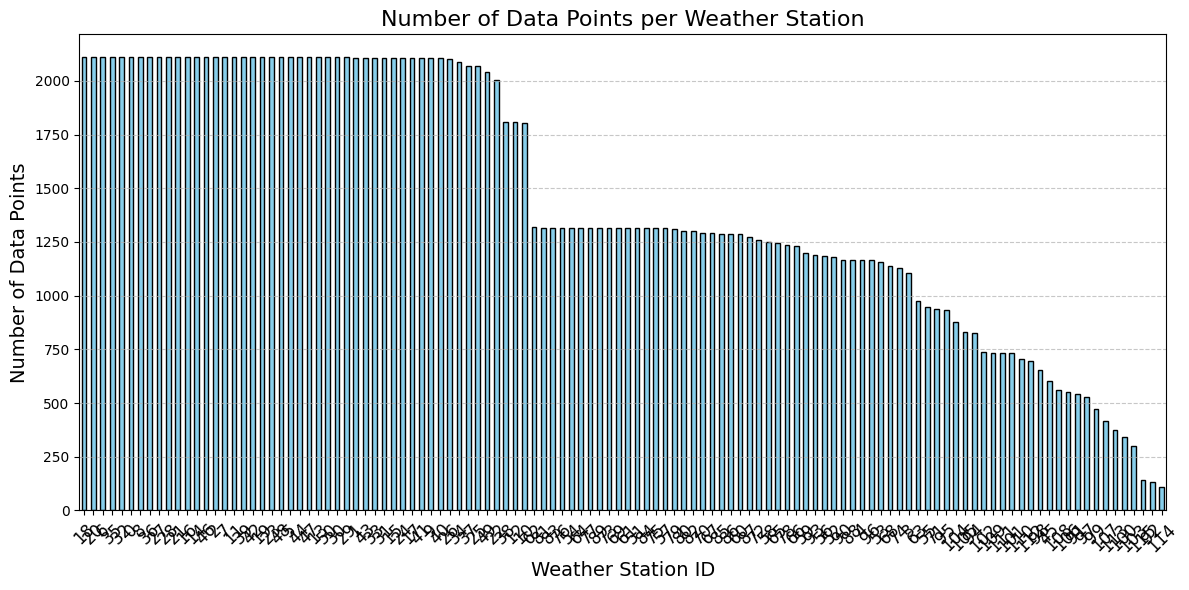

In [26]:
station_counts = combined_df['STATION_ID'].value_counts()
plt.figure(figsize=(12, 6))
station_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Data Points per Weather Station', fontsize=16)
plt.xlabel('Weather Station ID', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

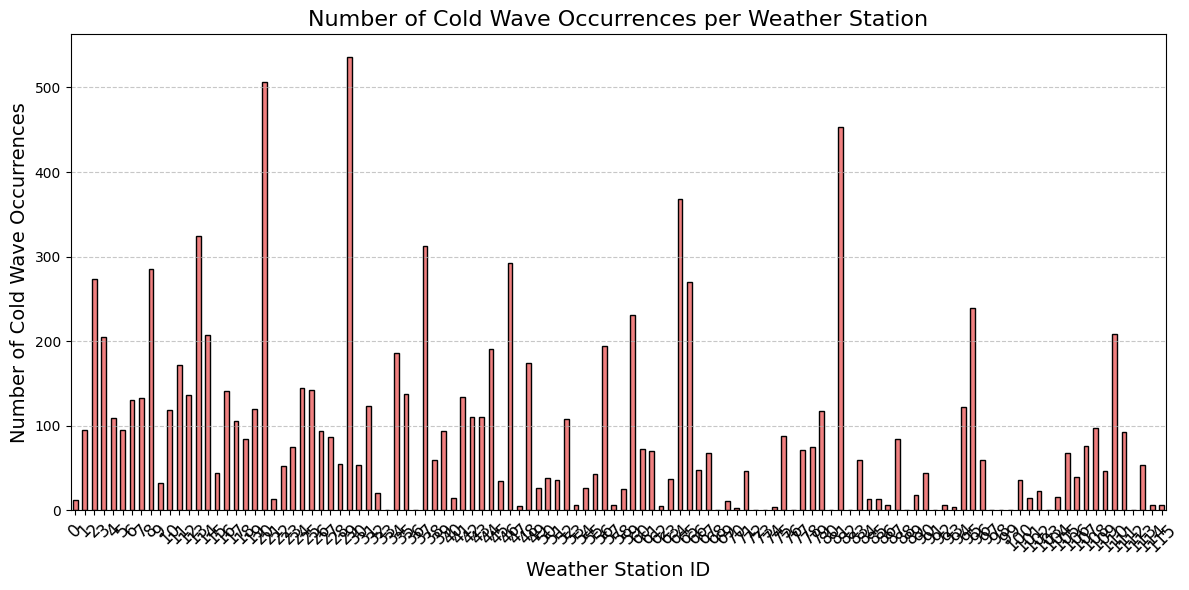

In [27]:
cold_wave_counts = combined_df.groupby('STATION_ID')['cold_wave'].sum()
plt.figure(figsize=(12, 6))
cold_wave_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Number of Cold Wave Occurrences per Weather Station', fontsize=16)
plt.xlabel('Weather Station ID', fontsize=14)
plt.ylabel('Number of Cold Wave Occurrences', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


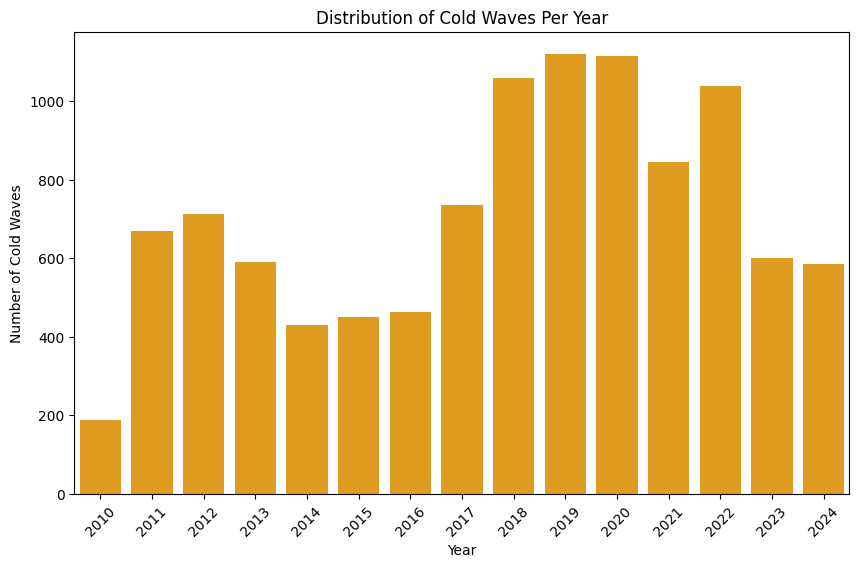

In [ ]:
combined_df['Year'] = pd.to_datetime(combined_df['DATE']).dt.year

# Count the number of cold waves per year
cold_wave_per_year = combined_df[combined_df['cold_wave'] == 1].groupby('Year').size()
plt.figure(figsize=(10, 6))
sns.barplot(x=cold_wave_per_year.index, y=cold_wave_per_year.values, color='orange')
plt.xlabel('Year')
plt.ylabel('Number of Cold Waves')
plt.title('Distribution of Cold Waves Per Year')
plt.xticks(rotation=45)
#plt.savefig("CW dist year wise.png")
plt.show()

In [29]:
combined_df['PRCP'] = combined_df['PRCP'].astype(bool)
combined_df['TAG'] = combined_df['TAG'].astype(bool)
combined_df['cold_wave'] = combined_df['cold_wave'].astype(bool)

In [30]:
station_counts = combined_df['STATION_ID'].value_counts()
# Filter out stations with less than 1000 occurrences
valid_stations = station_counts[station_counts >= 100].index
filtered_combined_df = combined_df[combined_df['STATION_ID'].isin(valid_stations)]
print(f"Filtered dataset contains {filtered_combined_df['STATION_ID'].nunique()} stations.")

Filtered dataset contains 116 stations.


In [31]:
filter_combined_df = filtered_combined_df[filtered_combined_df['MIN'] < 50]
combined_df = filter_combined_df

In [32]:
filtered_combined_df = combined_df[combined_df['MAX'] < 50]
combined_df = filtered_combined_df

In [33]:
#combined_df = pd.read_csv("DATASET.csv")
combined_df = combined_df.drop_duplicates()
#combined_df = combined_df.drop(columns=['Unnamed: 0'])
unique_stations = combined_df['STATION_ID'].unique()
df_unique_stations = combined_df.groupby('DATE').agg({'STATION_ID': 'nunique'}).reset_index()
df_unique_stations.columns = ['DATE', 'NUM_UNIQUE_STATIONS']
df_unique_stations['DATE'] = pd.to_datetime(df_unique_stations['DATE']) 
df_unique_stations = df_unique_stations.sort_values(by='DATE') 

In [ ]:
#First 5 years data as calculated having toal node set to be 51
first_792_dates = df_unique_stations['DATE'][:792]
combined_df['DATE'] = pd.to_datetime(combined_df['DATE'])
part_1 = combined_df[combined_df['DATE'].isin(first_792_dates)]
part_2 = combined_df[~combined_df['DATE'].isin(first_792_dates)]
#Filter out those outlier dates in the second part of the dataset having less than 75 unique number of stations on that particular day
valid_dates = df_unique_stations[df_unique_stations['NUM_UNIQUE_STATIONS'] >= 75]['DATE']
filtered_part_2 = part_2[part_2['DATE'].isin(valid_dates)]
print(f"Part 1 shape: {part_1.shape}")
print(f"Part 2 shape: {part_2.shape}")

Part 1 shape: (38813, 27)
Part 2 shape: (129144, 27)


In [35]:
part_1_counts = part_1['cold_wave'].value_counts()
part_2_counts = part_2['cold_wave'].value_counts()
print("Cold wave counts in Part 1:")
print(part_1_counts)
print("\nCold wave counts in Part 2:")
print(part_2_counts)

Cold wave counts in Part 1:
cold_wave
False    36062
True      2751
Name: count, dtype: int64

Cold wave counts in Part 2:
cold_wave
False    121292
True       7852
Name: count, dtype: int64


Data Augmentation so that each day in both parts has fixed number of nodes

For part_1 (2010-2015)

In [36]:
max_nodes_part_1 = 51
print(f"Size of part_1 before augmentation: {part_1.shape}")

part_1 = part_1.copy()

part_1['Year'] = pd.to_datetime(part_1['DATE']).dt.year
part_1['MONTH'] = pd.to_datetime(part_1['DATE']).dt.month

part_1['IS_AUGMENTED'] = 0  
unique_stations_per_day = part_1.groupby('DATE')['STATION_ID'].nunique()

for date, num_stations in unique_stations_per_day.items():
    if num_stations < max_nodes_part_1:
        missing_stations = set(part_1['STATION_ID'].unique()) - set(part_1[part_1['DATE'] == date]['STATION_ID'].unique())
        missing_data = pd.DataFrame({
            'DATE': [date] * len(missing_stations),
            'STATION_ID': list(missing_stations),
            'IS_AUGMENTED': 1  
        })

        missing_data['Year'] = pd.to_datetime(missing_data['DATE']).dt.year
        missing_data['MONTH'] = pd.to_datetime(missing_data['DATE']).dt.month
        
        for col in ['NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']:
            missing_data[col] = missing_data['STATION_ID'].map(part_1.groupby('STATION_ID')[col].first())

        for col in ['MAX', 'MIN', 'MXSPD', 'TEMP', 'Temperature', 'DEWP']:
            missing_data[col] = missing_data.apply(
                lambda row: part_1[(part_1['STATION_ID'] == row['STATION_ID']) & 
                                   (part_1['MONTH'] == row['MONTH'])][col].mean(),
                axis=1
            )

        for col in ['TAG', 'PRCP', 'cold_wave']:
            missing_data[col] = missing_data.apply(
                lambda row: part_1[(part_1['STATION_ID'] == row['STATION_ID']) & 
                                   (part_1['MONTH'] == row['MONTH'])][col].mode()[0]
                if not part_1[(part_1['STATION_ID'] == row['STATION_ID']) & 
                              (part_1['MONTH'] == row['MONTH'])][col].mode().empty else None,
                axis=1
            )

        part_1 = pd.concat([part_1, missing_data], ignore_index=True)

print(f"Size of part_1 after augmentation: {part_1.shape}")

Size of part_1 before augmentation: (38813, 27)


Size of part_1 after augmentation: (40392, 29)


For part_2 (2015-2024)

In [37]:
max_nodes_part_2 = 115
part_2 = filtered_part_2.copy()
print(f"Size of part_2 before augmentation: {part_2.shape}")
part_2['Year'] = pd.to_datetime(part_2['DATE']).dt.year
part_2['MONTH'] = pd.to_datetime(part_2['DATE']).dt.month
part_2['IS_AUGMENTED'] = 0  

unique_stations_per_day = part_2.groupby('DATE')['STATION_ID'].nunique()

for date, num_stations in unique_stations_per_day.items():
    if num_stations < max_nodes_part_2:
        existing_stations = set(part_2[part_2['DATE'] == date]['STATION_ID'])
        all_stations = set(part_2['STATION_ID'].unique())
        missing_stations = list(all_stations - existing_stations)[:max_nodes_part_2 - num_stations]

        missing_data = pd.DataFrame({'DATE': [date] * len(missing_stations), 'STATION_ID': missing_stations})
        missing_data['Year'] = pd.to_datetime(missing_data['DATE']).dt.year
        missing_data['MONTH'] = pd.to_datetime(missing_data['DATE']).dt.month
        missing_data['IS_AUGMENTED'] = 1  
        for col in ['NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']:
            missing_data[col] = missing_data['STATION_ID'].map(part_2.groupby('STATION_ID')[col].first())

        for col in ['MAX', 'MIN', 'MXSPD', 'TEMP', 'Temperature', 'DEWP']:
            missing_data[col] = missing_data.apply(
                lambda row: (
                    part_2[(part_2['STATION_ID'] == row['STATION_ID']) & (part_2['MONTH'] == row['MONTH'])][col].mean()
                    if not part_2[(part_2['STATION_ID'] == row['STATION_ID']) & (part_2['MONTH'] == row['MONTH'])].empty
                    else part_2[part_2['STATION_ID'] == row['STATION_ID']][col].mean()
                ),
                axis=1
            )

        for col in ['TAG', 'PRCP', 'cold_wave']:
            missing_data[col] = missing_data.apply(
                lambda row: (
                    part_2[(part_2['STATION_ID'] == row['STATION_ID']) & (part_2['MONTH'] == row['MONTH'])][col].mode()[0]
                    if not part_2[(part_2['STATION_ID'] == row['STATION_ID']) & (part_2['MONTH'] == row['MONTH'])][col].mode().empty
                    else part_2[part_2['STATION_ID'] == row['STATION_ID']][col].mode()[0]
                    if not part_2[part_2['STATION_ID'] == row['STATION_ID']][col].mode().empty else None
                ),
                axis=1
            )

        missing_data = missing_data[~missing_data[['DATE', 'STATION_ID']].duplicated()]
        part_2 = pd.concat([part_2, missing_data], ignore_index=True)

print(f"Size of part_2 after augmentation: {part_2.shape}")
print("Augmented Data Count:", part_2['IS_AUGMENTED'].sum())
print("Original Data Count:", len(part_2) - part_2['IS_AUGMENTED'].sum())

Size of part_2 before augmentation: (128571, 27)


Size of part_2 after augmentation: (150535, 29)
Augmented Data Count: 21964
Original Data Count: 128571


Manipulation on the augmented data only

In [38]:
def is_cold_wave(row):
    # Only apply if the data point is augmented
    if row['IS_AUGMENTED'] == 1:
        if row['TAG'] == 'HILLY' and row['MIN'] <= 0 and (row['Temperature'] - row['MIN']) >= 4.5:
            return 1
        if row['TAG'] == 'NOT HILLY' and row['MIN'] <= 10 and (row['Temperature'] - row['MIN']) >= 4.5:
            return 1
        return 0
    # For non-augmented data, return existing value or default (0 if not set)
    return row.get('cold_wave', 0)  

part_1['cold_wave'] = part_1.apply(is_cold_wave, axis=1)
part_2['cold_wave'] = part_2.apply(is_cold_wave, axis=1)

print("part_1 cold_wave distribution:")
print(part_1[['IS_AUGMENTED', 'cold_wave']].value_counts().sort_index())
print("\npart_2 cold_wave distribution:")
print(part_2[['IS_AUGMENTED', 'cold_wave']].value_counts().sort_index())

part_1 cold_wave distribution:
IS_AUGMENTED  cold_wave
0             False        36062
              True          2751
1             False         1579
Name: count, dtype: int64

part_2 cold_wave distribution:
IS_AUGMENTED  cold_wave
0             False        120730
              True           7841
1             False         21964
Name: count, dtype: int64


ADDING A NEW FEATURE - ONI_INDEX

In [40]:
#Can be found on the web.
oni_data = {
    'Year': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
    'Jan': [np.nan, -1.6, -1.0, -0.2, -0.3, 0.7, 2.6, -0.6, -1.0, 0.8, 0.5, -1.2, -1.0, -0.8, 2.0, -0.475],
    'Feb': [np.nan, -1.4, -0.9, -0.4, -0.4, 0.5, 2.5, -0.3, -0.9, 0.7, 0.5, -1.0, -1.0, -0.7, 1.8, -0.496],
    'Mar': [np.nan, -1.2, -0.7, -0.4, -0.5, 0.5, 2.1, -0.2, -0.9, 0.7, 0.5, -0.9, -0.9, -0.4, 1.5, -0.415],
    'Nov': [-1.6, -1.0, 0.3, -0.2, 0.5, 2.4, -0.7, -0.7, 0.8, 0.3, -1.2, -0.8, -1.0, 1.8, -0.3, np.nan],
    'Dec': [-1.6, -1.1, 0.1, -0.2, 0.6, 2.6, -0.7, -0.8, 0.9, 0.5, -1.3, -1.0, -0.9, 1.9, -0.4, np.nan]
}

oni_df = pd.DataFrame(oni_data)
oni_df_melted = oni_df.melt(id_vars=['Year'], 
                            value_vars=['Jan', 'Feb', 'Mar', 'Nov', 'Dec'], 
                            var_name='Month', 
                            value_name='ONI_index')

month_mapping = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Nov': 11,
    'Dec': 12
}
oni_df_melted['Month'] = oni_df_melted['Month'].map(month_mapping)
oni_df_melted = oni_df_melted.dropna(subset=['ONI_index'])
oni_index_data = {(row['Year'], row['Month']): row['ONI_index'] for _, row in oni_df_melted.iterrows()}

#part_1 = pd.read_csv('datasets/part_1.csv')
#part_2 = pd.read_csv('datasets/part_2.csv')

def add_oni_index(df, oni_index_data):
    
    required_columns = ['Year', 'MONTH']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns in DataFrame: {missing_columns}")
    
    df['Year'] = df['Year'].astype(int)
    df['MONTH'] = df['MONTH'].astype(int)
    
    def map_oni_index(row):
        year = row['Year']
        month = row['MONTH']
        key = (year, month)
        return oni_index_data.get(key, np.nan)
    
    df['ONI_index'] = df.apply(map_oni_index, axis=1)
    
    if df['ONI_index'].isna().any():
        print(f"Warning: Some rows have missing ONI Index values. Total missing: {df['ONI_index'].isna().sum()}")
        print("This may be because ONI Index values are only provided for January, February, March, November, and December.")
    
    return df

part_1 = add_oni_index(part_1, oni_index_data)
part_2 = add_oni_index(part_2, oni_index_data)

#part_1 = part_1.drop(columns=['Unnamed: 0'])
#part_2 = part_2.drop(columns=['Unnamed: 0'])
#part_1.to_csv('datasets/part_1.csv', index=False)
#part_2.to_csv('datasets/part_2.csv', index=False)

print("ONI Index added to part_1 and part_2 successfully.")
print(f"part_1 shape: {part_1.shape}")
print(f"part_2 shape: {part_2.shape}")
print("\nSample of part_1 with ONI_index:")
print(part_1[['Year', 'MONTH', 'ONI_index']].head())
print("\nSample of part_2 with ONI_index:")
print(part_2[['Year', 'MONTH', 'ONI_index']].head())

ONI Index added to part_1 and part_2 successfully.
part_1 shape: (40392, 30)
part_2 shape: (150535, 30)

Sample of part_1 with ONI_index:
   Year  MONTH  ONI_index
0  2010     11       -1.6
1  2010     11       -1.6
2  2010     11       -1.6
3  2010     11       -1.6
4  2010     11       -1.6

Sample of part_2 with ONI_index:
   Year  MONTH  ONI_index
0  2015     12        2.6
1  2015     12        2.6
2  2015     12        2.6
3  2015     12        2.6
4  2015     12        2.6


In [48]:
# Columns to drop
cols_to_drop = [
    'DEWP_ATTRIBUTES', 'FRSHTT_ATTRIBUTES', 'GUST_ATTRIBUTES',
    'MAX_ATTRIBUTES', 'MIN_ATTRIBUTES', 'MXSPD_ATTRIBUTES',
    'PRCP_ATTRIBUTES', 'SLP_ATTRIBUTES', 'SNDP_ATTRIBUTES',
    'STP_ATTRIBUTES', 'TEMP_ATTRIBUTES'
]

part_1_processed = part_1.drop(columns=cols_to_drop, errors='ignore')
output_path = "data/datasets/part_1_processed.csv"
part_1_processed.to_csv(output_path, index=False)

part_2_processed = part_2.drop(columns=cols_to_drop, errors='ignore')
output_path = "data/datasets/part_2_processed.csv"
part_1_processed.to_csv(output_path, index=False)